# Mathematical Acrobatics
## Group Members: Johnson Lien, Sam Goldwasser, Shihan Zhao
This code looks at ["Ensemble Learning for Housing Market Predictions"](https://www.kaggle.com/rezameri/ensemble-learning-for-housing-market-predictions). Near the end, the  looks at averaging the different base models used and then further enhances it to improve the score. I stopped at just averaging the different models because I do not understand what is going on at the last few steps.

To summarize what was done, we used ensemble learning technique to improve the prediction score. [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning) is just using different prediction methods and combining them to improve predictions. In this notebook, we used ElasticNet Regression, Lasso, XGBoost, and Kernel Ridge Regression. 

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 80)
pd.options.mode.chained_assignment = None
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew
import copy
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder

In [2]:
# import input files
# ../input/house-prices-advanced-regression-techniques/train.csv
# ../input/house-prices-advanced-regression-techniques/test.csv
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
df_all = pd.concat((df_train, df_test))

In [3]:
print("The initial training dataset size is: {}".format(df_train.shape))
print("The initial testing dataset size is: {}".format(df_test.shape))

The initial training dataset size is: (1460, 80)
The initial testing dataset size is: (1459, 79)


In [4]:
# Many guides have mentioned that these two columns contain pretty much just 1 value each,
# so they don't provide much information and can be safely disregarded
df_all.drop(columns=['Street','Utilities'], axis=1, inplace=True)

<span style="color:red">NOTE1: There was a block here that removed "Id" columns, This has been moved to read_csv.</span>

# 1. Data exploration and preprocessing
In this section we will focus on analyzing the data and removing outliers when necessary. We will also transform some of the data using log functions to make some of the features more normally distributed. <span style="color:red">NOTE2: I think this guide explains a lot on why we want to transform: https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing</span>

Our goal here is to eventually make all predictive features, from both the training and test datasets, to be numerically encoded and scaled, and to make the target feature centered. Most models assume these things about the data set. Our strategy here goes in the following order:

1. Separate non-nominal variables from nominal variables and fill NA's
2. Fill NA's
3. Apply the proper encodings to make all columns have either int64 or float64 datatypes
4. Detect and remove outliers
5. Transforming the target and highly-skewed predictors
6. Scaling everything

<span style="color:red">NOTE3: I have moved the feature correlation plots and outlier plots(1.1 and 1.2) lower to 1.4,  Missing Data(2.1) to 1.2, and encoding("Transforming some numerical variables that are really categorical" and "Label Encoding some categorical variables that may contain information in their ordering set") to 1.3.</span>

## 1.1 Separating non-nominal variables from nominal variables
<span style="color:red">NOTE4: "non-nominal" really means numerical; "nominal" really means categorical.</span>
### 1.1.1 Column dtype is a good starting point

In [5]:
non_nominal_vars = df_all.select_dtypes(include = ['int64', 'float64'])
non_nominal_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   LotFrontage    2433 non-null   float64
 2   LotArea        2919 non-null   int64  
 3   OverallQual    2919 non-null   int64  
 4   OverallCond    2919 non-null   int64  
 5   YearBuilt      2919 non-null   int64  
 6   YearRemodAdd   2919 non-null   int64  
 7   MasVnrArea     2896 non-null   float64
 8   BsmtFinSF1     2918 non-null   float64
 9   BsmtFinSF2     2918 non-null   float64
 10  BsmtUnfSF      2918 non-null   float64
 11  TotalBsmtSF    2918 non-null   float64
 12  1stFlrSF       2919 non-null   int64  
 13  2ndFlrSF       2919 non-null   int64  
 14  LowQualFinSF   2919 non-null   int64  
 15  GrLivArea      2919 non-null   int64  
 16  BsmtFullBath   2917 non-null   float64
 17  BsmtHalfBath   2917 non-null   float64
 18  FullBath

In [6]:
nominal_vars = df_all.select_dtypes(include = ['object'])
nominal_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       2915 non-null   object
 1   Alley          198 non-null    object
 2   LotShape       2919 non-null   object
 3   LandContour    2919 non-null   object
 4   LotConfig      2919 non-null   object
 5   LandSlope      2919 non-null   object
 6   Neighborhood   2919 non-null   object
 7   Condition1     2919 non-null   object
 8   Condition2     2919 non-null   object
 9   BldgType       2919 non-null   object
 10  HouseStyle     2919 non-null   object
 11  RoofStyle      2919 non-null   object
 12  RoofMatl       2919 non-null   object
 13  Exterior1st    2918 non-null   object
 14  Exterior2nd    2918 non-null   object
 15  MasVnrType     2895 non-null   object
 16  ExterQual      2919 non-null   object
 17  ExterCond      2919 non-null   object
 18  Foundation     2919 non-null

### 1.1.2 Finding pseudo-nominal variables
Some variables, although haveing int64 or float64 dtypes, are actually nominal variables in disguise. Taking the feature MoSold (standing for 'Month Sold') for example, we note that its values' order does not have any inherent meaning--that is, it's not obvious how a house sold in Feburary might be more different from one sold in January than one sold in December.

#### 1.1.2.1 Distribution plot
This distribution plot is plotted on all variables that have either int64 or float64 dtype. We include this plot primarily to find variables that appear to be discrete, and thus potentially nominal. This plot also gives a good overview of feature skewness.

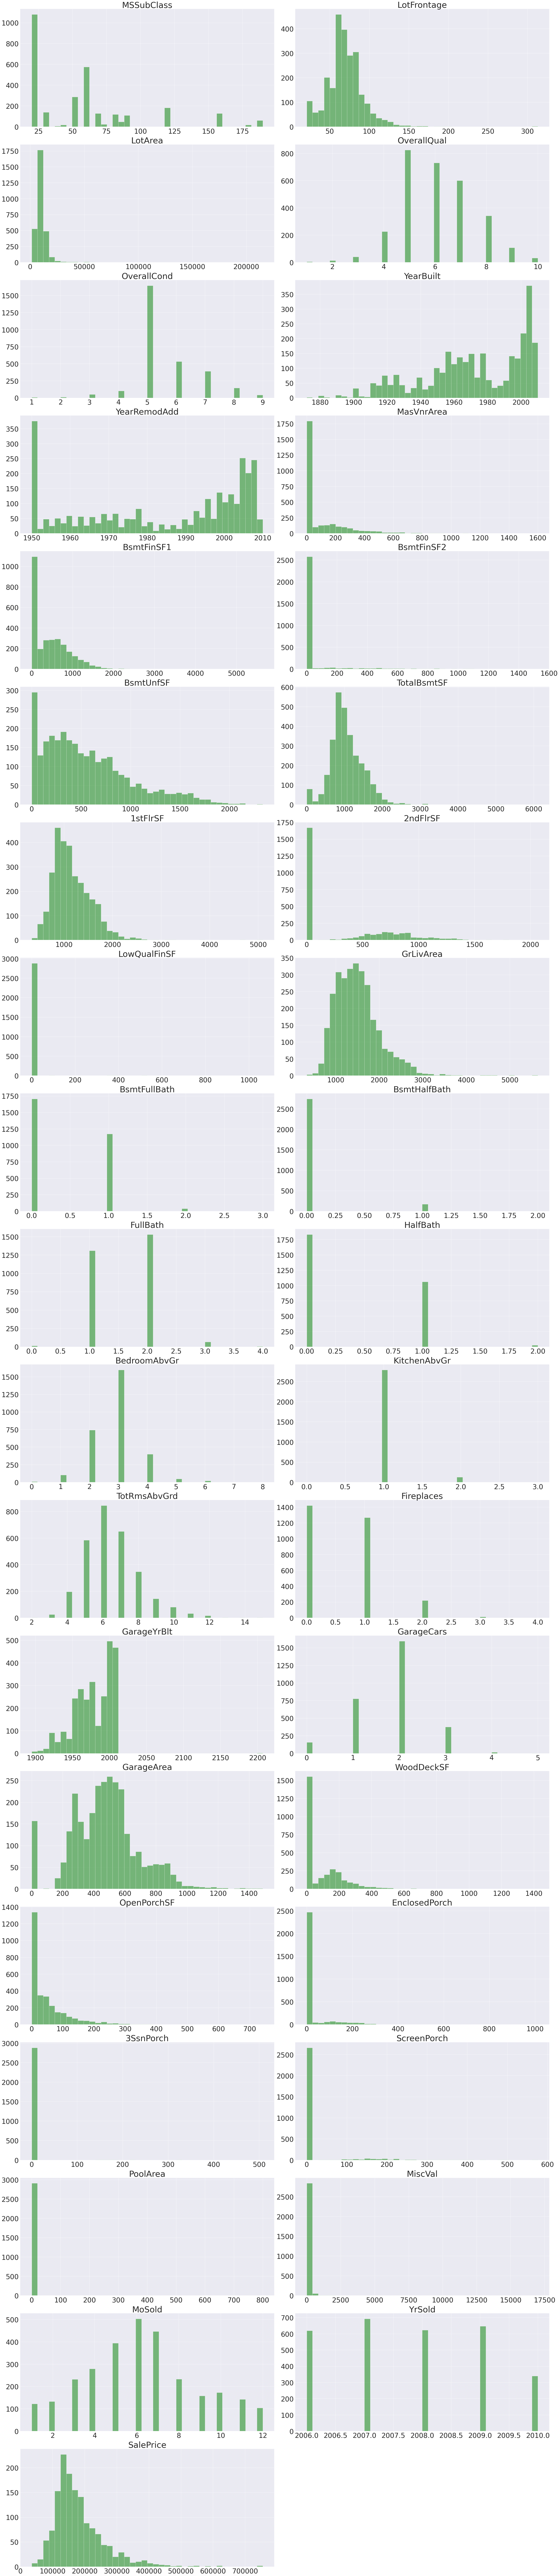

In [7]:
fig=plt.figure()
for i, var_name in enumerate(non_nominal_vars.columns):
    ax=fig.add_subplot(19,2,i+1)
    non_nominal_vars[var_name].hist(bins=40,ax=ax,color = 'green',alpha=0.5, figsize = (40, 200))
    ax.set_title(var_name, fontsize = 43)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 35)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 35)
    ax.set_xlabel('')
fig.tight_layout(rect = [0, 0.03, 1, 0.95])  # Improves appearance a bit.
plt.show()

#### 1.1.2.2 Further inspection by eyeballing relationship with SalePrice
From the distribution plot above, we found a few suspects and record them here in possible_nominal_cols. We inspect them further here by making their scatter plots against SalePrice. Those with no obvious relationship with SalePrice will be reckoned nominal. We identify <b>MSSubClass</b>, <b>MoSold</b>, and <b>YrSold</b> as pseudo-nominal variables.

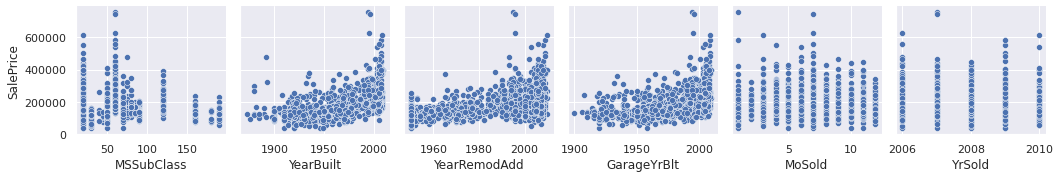

In [8]:
sns.set()
possible_nominal_cols = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
sns.pairplot(data=non_nominal_vars, x_vars=possible_nominal_cols, y_vars=['SalePrice'], height = 2.5)
plt.show()

### 1.1.3 Finding pseudo-non-nominal variables
Contrary to pseudo-nominal variables, we refer to pseudo-non-nominal variables as variables that have object dtype, but whose values can be ordered in a meaningful way upon closer inspection, making them fit for ordinal encoding, which will turn them into essentially non-nominal variables. Unfortunately, we do not have a more rigorous way other than to inspect the feature description. We record the pseudo-non-nominal variables we found here:

Note:
- Some variables have a NA level, which is wrongfully read by pandas as NaN, i.e. lacking information, whereas it actually means something more resembling of 'not applicable'. For example, NA in the variable BsmtQual (which stands for BaSeMenT QUALity) means not having a basement, not no information. Intuitively, having no basement is worse than having a poorly conditioned basement. Therefore we follow this intuition and encode NaN's in each variable as its lowest level, 'None'.

In [9]:
pseudo_non_nominal_levels = {
    'ExterQual':['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond':['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual':['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure':['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1':['None', 'Unf', 'LwQ', 'Rec', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2':['None', 'Unf', 'LwQ', 'Rec', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC':['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual':['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'FireplaceQu':['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish':['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual':['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond':['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive':['None', 'N', 'P', 'Y'],
    'PoolQC':['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence':['None', 'MnWw', 'MnPrv', 'GdWo', 'GdPrv'] #FIXME
}

Aside from the ones that are obvious from feature description, a lot of the nominal features can actually be ordinally encoded simply because their levels have an inherent ordering. For example, <b>Neighborhood</b> may be ordinally encoded because houses in the same neighborhood tend to be generally similar, and some neighborhoods might be more "high-end" than others. However, we also note that this kind of encoding might not entirely capture all the information in the feature, so we only do this on the more prominent features with many levels and relatively obvious inherent ordering. We'll also consider if the ranking matches our intuition and if there are enough samples for each group.

In [10]:
# A typical example where the encoding works - many levels, clear ordering, enough data for all levels
pd.concat({"mean_price": df_all.groupby('Neighborhood')['SalePrice'].mean(),
           "num_samples": df_all['Neighborhood'].value_counts()}, axis=1).sort_values(by='mean_price')

,mean_price,num_samples
MeadowV,98576.470588,37
IDOTRR,100123.783784,93
BrDale,104493.750000,30
BrkSide,124834.051724,108
Edwards,128219.700000,194
OldTown,128225.300885,239
Sawyer,136793.135135,151
Blueste,137500.000000,10
SWISU,142591.360000,48
NPkVill,142694.444444,23


In [11]:
# An example where the encoding might not work - unintuitive ordering, few levels, not enough data for some levels
pd.concat({"mean_price": df_all.groupby('Heating')['SalePrice'].mean(),
           "num_samples": df_all['Heating'].value_counts()}, axis=1).sort_values(by='mean_price')

,mean_price,num_samples
Floor,72500.000000,1
Grav,75271.428571,9
Wall,92100.000000,6
OthW,125750.000000,2
GasW,166632.166667,27
GasA,182021.195378,2874


In the end, the features we select are <b>Neighborhood</b>, <b>MSSubClass</b>(guess we are moving it back...), <b>Exterior1st</b>, <b>Exterior2nd</b>, <b>HouseStyle</b>, <b>Functional</b>, <b>GarageType</b>, <b>BldgType</b>, <b>MSZoning</b>. We rank the levels by their mean SalePrice within group, and use the means as encoding. We also scale these encodings to [0,1] by min-max scaling.

In [12]:
scaled_encodings = {}
# Exterior1st and Exterior2nd can use the same encoding
# Some unmatching indices, probably mistyped, need to manually fill
exterior1and2 = pd.concat({'Exterior1st': df_all.groupby('Exterior1st')['SalePrice'].mean(),
                           'Exterior2nd': df_all.groupby('Exterior2nd')['SalePrice'].mean()}, axis=1)
exterior1and2.at['BrkComm','Exterior2nd'] = exterior1and2.at['Brk Cmn','Exterior2nd']
exterior1and2.at['Brk Cmn','Exterior1st'] = exterior1and2.at['BrkComm','Exterior1st']
exterior1and2.at['CemntBd','Exterior2nd'] = exterior1and2.at['CmentBd','Exterior2nd']
exterior1and2.at['CmentBd','Exterior1st'] = exterior1and2.at['CemntBd','Exterior1st']
exterior1and2.at['WdShing','Exterior2nd'] = exterior1and2.at['Wd Shng','Exterior2nd']
exterior1and2.at['Wd Shng','Exterior1st'] = exterior1and2.at['WdShing','Exterior1st']
mean_by_exterior1and2 = exterior1and2.mean(axis=1).sort_values()
exterior1and2_encodings = pd.Series(MinMaxScaler().fit_transform(mean_by_exterior1and2.values.reshape(-1,1)).flatten(), index=mean_by_exterior1and2.index)
scaled_encodings['Exterior1st'] = exterior1and2_encodings
scaled_encodings['Exterior2nd'] = exterior1and2_encodings

In [13]:
features_2b_encoded = ['Neighborhood','MSSubClass','HouseStyle','Functional','GarageType','BldgType','MSZoning']
for f in features_2b_encoded:
    mean_by_f = df_all.groupby(f)['SalePrice'].mean().sort_values()
    mean_by_f.fillna(mean_by_f.mean(), inplace=True)
    f_encodings = pd.Series(MinMaxScaler().fit_transform(mean_by_f.values.reshape(-1,1)).flatten(), index=mean_by_f.index)
    scaled_encodings[f] = f_encodings
scaled_encodings

{'Exterior1st': BrkComm    0.000000
 Brk Cmn    0.000000
 CBlock     0.027904
 AsbShng    0.053901
 AsphShn    0.091499
 Wd Sdng    0.228291
 MetalSd    0.230557
 WdShing    0.259535
 Wd Shng    0.259535
 Stucco     0.275232
 HdBoard    0.302133
 Plywood    0.332376
 BrkFace    0.437617
 Stone      0.497428
 VinylSd    0.523413
 CemntBd    0.599770
 CmentBd    0.599770
 ImStucc    0.718524
 Other      1.000000
 dtype: float64,
 'Exterior2nd': BrkComm    0.000000
 Brk Cmn    0.000000
 CBlock     0.027904
 AsbShng    0.053901
 AsphShn    0.091499
 Wd Sdng    0.228291
 MetalSd    0.230557
 WdShing    0.259535
 Wd Shng    0.259535
 Stucco     0.275232
 HdBoard    0.302133
 Plywood    0.332376
 BrkFace    0.437617
 Stone      0.497428
 VinylSd    0.523413
 CemntBd    0.599770
 CmentBd    0.599770
 ImStucc    0.718524
 Other      1.000000
 dtype: float64,
 'Neighborhood': Neighborhood
 MeadowV    0.000000
 IDOTRR     0.006537
 BrDale     0.024997
 BrkSide    0.110923
 Edwards    0.125225
 Ol

## 1.2 Fill NA's
<span style="color:red">NOTE5: This is essentially what our version 26 did in 2.1 Missing Data.</span>
### 1.2.1 Fillna for non-nominal variables
#### 1.2.1.1 Where are the NA's?

In [14]:
non_nominal_na_counts = non_nominal_vars.isnull().sum()[non_nominal_vars.isnull().any()].sort_values()
non_nominal_na_counts

BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
GarageCars         1
GarageArea         1
BsmtFullBath       2
BsmtHalfBath       2
MasVnrArea        23
GarageYrBlt      159
LotFrontage      486
SalePrice       1459
dtype: int64

#### 1.2.1.2 Fillna strategy
We suspect that NA's in Bsmt, Garage, and MasVnr features might correspond to no basement, no garage, or no masonry veneer, so we are going to check for NA's in <b>BsmtCond</b>, <b>GarageCond</b>, and <b>MasVnrType</b> columns.

In [15]:
nominal_vars['BsmtCond'].isnull().sum()

82

In [16]:
nominal_vars['GarageCond'].isnull().sum()

159

In [17]:
nominal_vars['MasVnrType'].isnull().sum()

24

As shown, there are far fewer NA's in Bsmt features than the number of houses that don't have basements, and the same applies for most Garage and MasVnr features as well, so those NA's probably correspond to input errors. Only features <b>MasVnrArea</b> and <b>GarageYrBlt</b> have comparable numbers of NA's as the number of houses that don't have those respective features. For no garage/masonry veneer NA's, we will fillna with 0's. For input errors, it is usually safe to fillna with medians.

For the <b>LotFrontage</b> column, we again draw from the observation that houses in the same neighborhood should be similar, and thus will fillna with the neighborhood LotFrontage mean.

#### 1.2.1.3 Fillna according to our decided strategy

In [18]:
# we fillna strictly according to row, in case NA rows and no garage/masonry veneer rows don't correspond
for i in nominal_vars.loc[nominal_vars['GarageCond'].isnull()].index:
    non_nominal_vars.at[i,'GarageYrBlt'] = 0
for i in nominal_vars.loc[nominal_vars['MasVnrType'].isnull()].index:
    non_nominal_vars.at[i,'MasVnrArea'] = 0
# verify that we filled the correct rows, and that no NA's are left in these 2 columns
non_nominal_vars[['GarageYrBlt','MasVnrArea']].isnull().any()

GarageYrBlt    False
MasVnrArea     False
dtype: bool

In [19]:
# fill input error NA's with medians
for c in non_nominal_na_counts.index[:8]:
    col_median = non_nominal_vars[c].median()
    non_nominal_vars[c].fillna(col_median, inplace=True)

In [20]:
# fill LotFrontage NA's with neighborhood mean
neighborhood_lotF_mean = df_all.groupby('Neighborhood')['LotFrontage'].mean()
for n in neighborhood_lotF_mean.index:
    non_nominal_vars.loc[(nominal_vars['Neighborhood']==n) & (non_nominal_vars['LotFrontage'].isnull()), 'LotFrontage'] = neighborhood_lotF_mean[n]    

Now we only have NA's left in <b>SalePrice</b> column, and we won't do anything about them because they are from the test set.

In [21]:
non_nominal_vars.isnull().sum()[non_nominal_vars.isnull().any()]

SalePrice    1459
dtype: int64

### 1.2.2 Fillna for nominal variables
#### 1.2.2.1 Where are the NA's?

In [22]:
nominal_na_counts = nominal_vars.isnull().sum()[nominal_vars.isnull().any()].sort_values()
nominal_na_counts

Electrical         1
KitchenQual        1
Exterior2nd        1
SaleType           1
Exterior1st        1
Functional         2
MSZoning           4
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtExposure      82
BsmtCond          82
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
FireplaceQu     1420
Fence           2348
Alley           2721
MiscFeature     2814
PoolQC          2909
dtype: int64

#### 1.2.2.2 Fillna strategy
From our experience filling NA's for non-nominal variables, we can tell NA's in the first 7 features with few NA's are probably input errors, and the rest are probably actually None's, so we will fillna accordingly.

In [23]:
nominal_na2mode_cols = nominal_na_counts.index[:7]
nominal_na2none_cols = nominal_na_counts.index[7:]
nominal_na_modes = nominal_vars[nominal_na2mode_cols].mode().iloc[0]

#### 1.2.2.3 Fillna according to our decided strategy

In [24]:
for c in nominal_na2mode_cols:
    nominal_vars[c].fillna(nominal_na_modes[c], inplace=True)
for c in nominal_na2none_cols:
    nominal_vars[c].fillna('None', inplace=True)

Sanity check.

In [25]:
nominal_vars.isnull().sum()[nominal_vars.isnull().any()]

Series([], dtype: int64)

Since the <b>GarageType</b> column is among the columns that have been filled, we need to update its scaled encoding entry. There are others such as <b>Exterior1st</b>, but they don't pose much of a problem because they have only less than 4 missing data that are filled with mode, and the mode levels usually already have enough data.

In [26]:
df_all_copy = copy.deepcopy(df_all)
df_all_copy['GarageType'].fillna('None', inplace=True)
mean_by_garagetype = df_all_copy.groupby('GarageType')['SalePrice'].mean().sort_values()
scaled_encodings['GarageType'] = pd.Series(MinMaxScaler().fit_transform(mean_by_garagetype.values.reshape(-1,1)).flatten(), index=mean_by_garagetype.index)

## 1.3 Applying the proper encodings
<span style="color:red">NOTE6: This is essentially "Transforming some numerical variables that are really categorical" and "Label Encoding some categorical variables that may contain information in their ordering set".</span>
### 1.3.1 Moving pseudo-nominal variables to the nominal set
We identified some pseudo-nominal variables in section 1.1.2; here we move them to the nominal set, so we may onehot-encode them later.

In [27]:
pseudo_nominal_cols = ['MSSubClass', 'MoSold', 'YrSold']
pseudo_nominal_vars = non_nominal_vars[pseudo_nominal_cols].astype('object')
nominal_vars = nominal_vars.join(pseudo_nominal_vars)
non_nominal_vars.drop(columns=pseudo_nominal_cols, inplace=True)

### 1.3.2 Ordinal encoding
We can now apply ordinal encoding on the pseudo-non-nominal variables, and move the encoded variables to the non-nominal set.

In [28]:
OD_enc = OrdinalEncoder(categories=[v for v in pseudo_non_nominal_levels.values()])
OD_features = OD_enc.fit_transform(nominal_vars[[k for k in pseudo_non_nominal_levels.keys()]])
OD_dataFrame = pd.DataFrame(data=OD_features, index=[i for i in range(1,df_all.shape[0]+1)], columns=[c for c in pseudo_non_nominal_levels.keys()])
non_nominal_vars = non_nominal_vars.join(OD_dataFrame)

We encode the features in <b>scaled_encodings</b> separately since they don't have the neatly leveled structure like other pseudo-non-nominal variables.

In [29]:
for f in scaled_encodings:
    OD_f = copy.deepcopy(nominal_vars[f])
    for i, n in enumerate(OD_f):
        # index starts at 1 not 0
        OD_f[i+1] = scaled_encodings[f][n]
    non_nominal_vars = non_nominal_vars.join(OD_f.astype('float64'))
nominal_vars.drop(columns=list(scaled_encodings.keys()), axis=1, inplace=True)

### 1.3.3 OneHot encoding
The variables that are truely nominal can be encoded by OneHot encoding. The results can then be added to the non-nominal set.

Note:
- For each OH-encoded variable, we keep track of which dummy variables it is encoded into; we might use this information later in group Lasso and feature importance tracking.

In [30]:
OH_enc = OneHotEncoder(drop='first')
OH_groups = []
col_counter = 0
for c in nominal_vars.columns:
    if c not in pseudo_non_nominal_levels.keys():
        OH_matrix = OH_enc.fit_transform(nominal_vars[c].values.reshape(-1,1)).toarray()
        OH_dataFrame = pd.DataFrame(data=OH_matrix, index=[i for i in range(1,df_all.shape[0]+1)], columns=[i for i in range(col_counter,col_counter+OH_matrix.shape[1])])
        non_nominal_vars = non_nominal_vars.join(OH_dataFrame)
        OH_groups += [c] * OH_matrix.shape[1]
        col_counter += OH_matrix.shape[1]

## 1.4 Detecting and removing outliers
<span style="color:red">NOTE7: This is actually now very different from version 26, PLEASE READ.</span>
We tend to be very cautious here because removing rows, even when they are outliers, means deleting information. We consider the test set along with the training set when looking for outliers, because the test set might contain similar outliers as the training set, in which case we should try to fit, rather than to remove, these outliers.

### 1.4.1 Feature Correlation
Let's take a look at feature correlation to see which features are more important than others so that we can focus more on them

<AxesSubplot:>

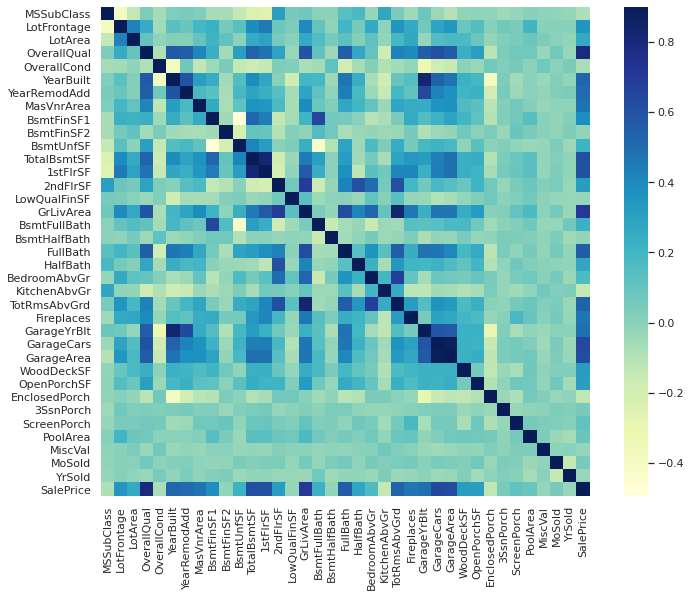

In [31]:
# Use a heatmap to show feature correlations
corrmat = df_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, cmap="YlGnBu", vmax=0.9, square=True)

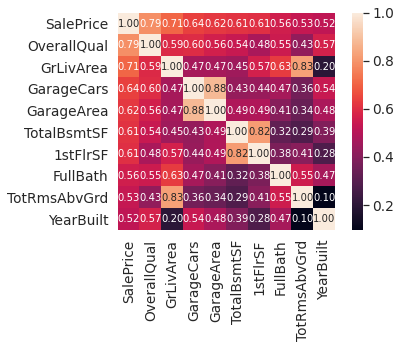

In [32]:
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The heatmap above shows the following features are highly correlated to 
SalePrice.
OverallQual, GrLivArea, GarageCars, GarageArea.
We can take a closer look at some of these features

### 1.4.2 Overview
We use the good'ol boxplots for detecting outliers. We only make boxplots of numerical features since those are the only ones that might have very wide range and therefore significant outliers. 

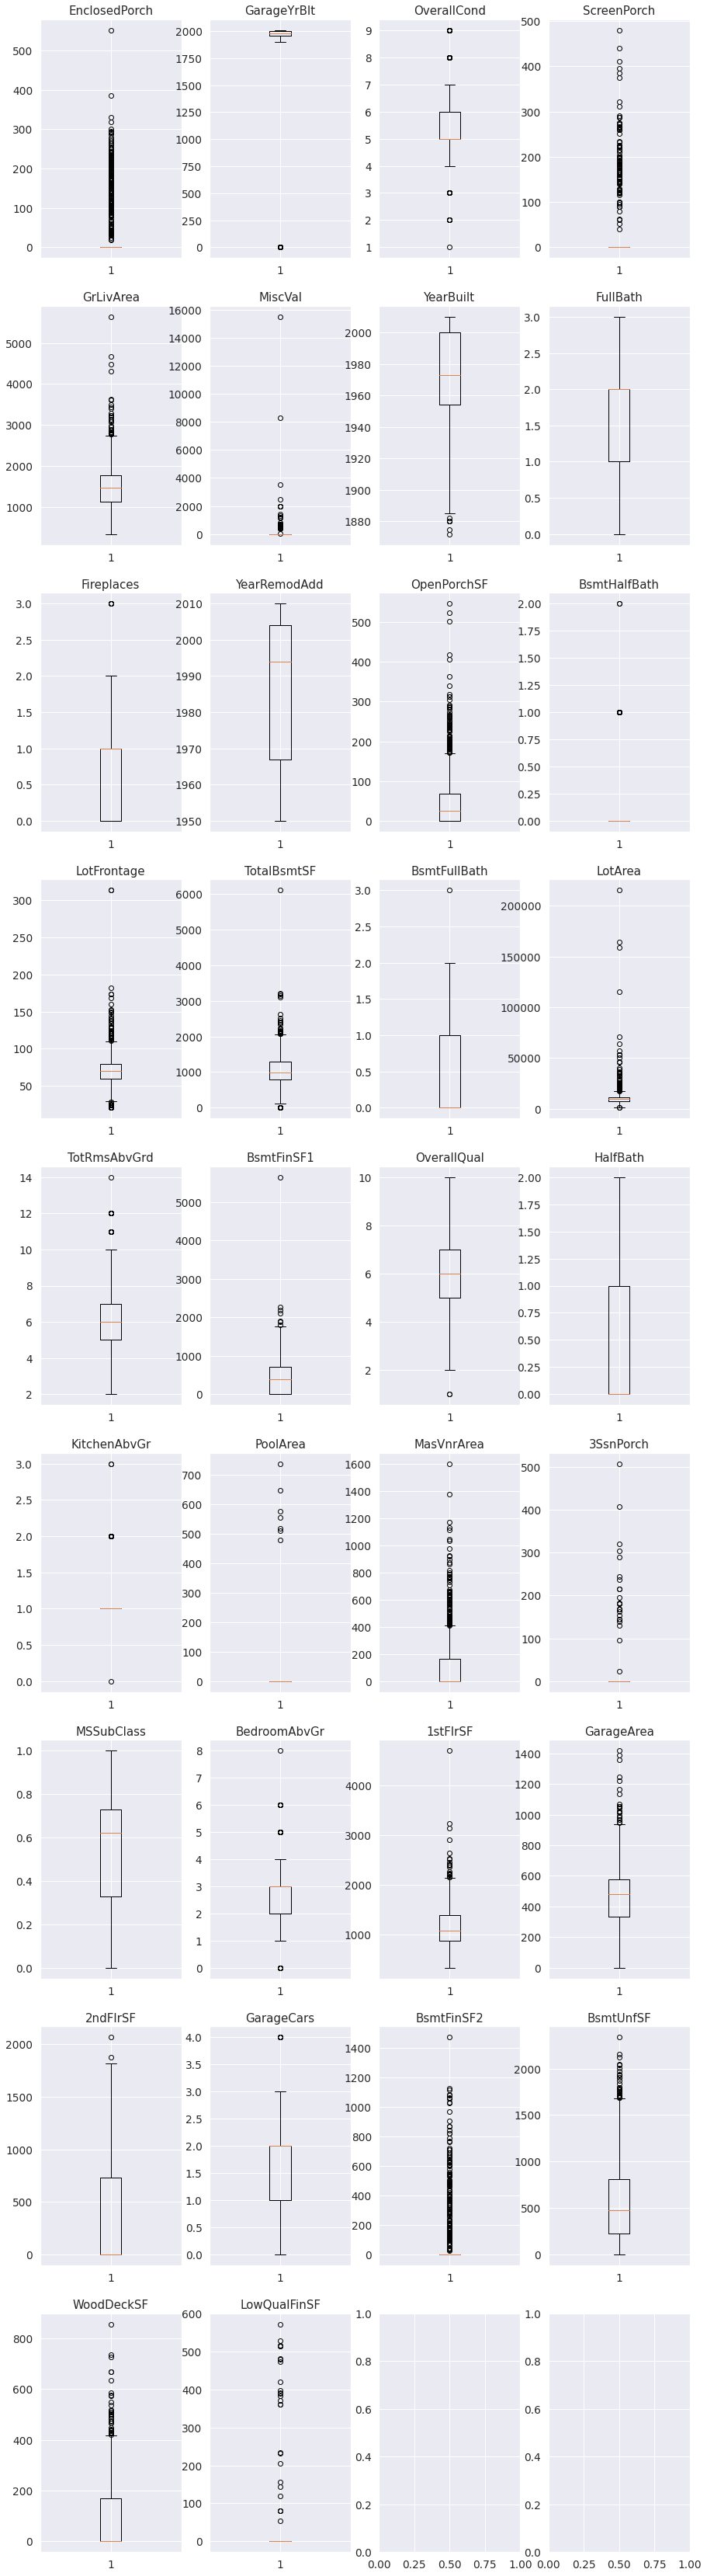

In [33]:
# boxplots for training data
possible_outlier_cols = set(df_all.select_dtypes(include = ['int64', 'float64']).columns) & set(non_nominal_vars.columns)
possible_outlier_cols.remove('SalePrice')
train_data_points = non_nominal_vars.drop(df_test.index)
fig, axs = plt.subplots(9,4,figsize=(15,60))
for i, var_name in enumerate(possible_outlier_cols):
    axs[i//4,i%4].boxplot(train_data_points[var_name])
    axs[i//4,i%4].set_title(var_name)
plt.show()

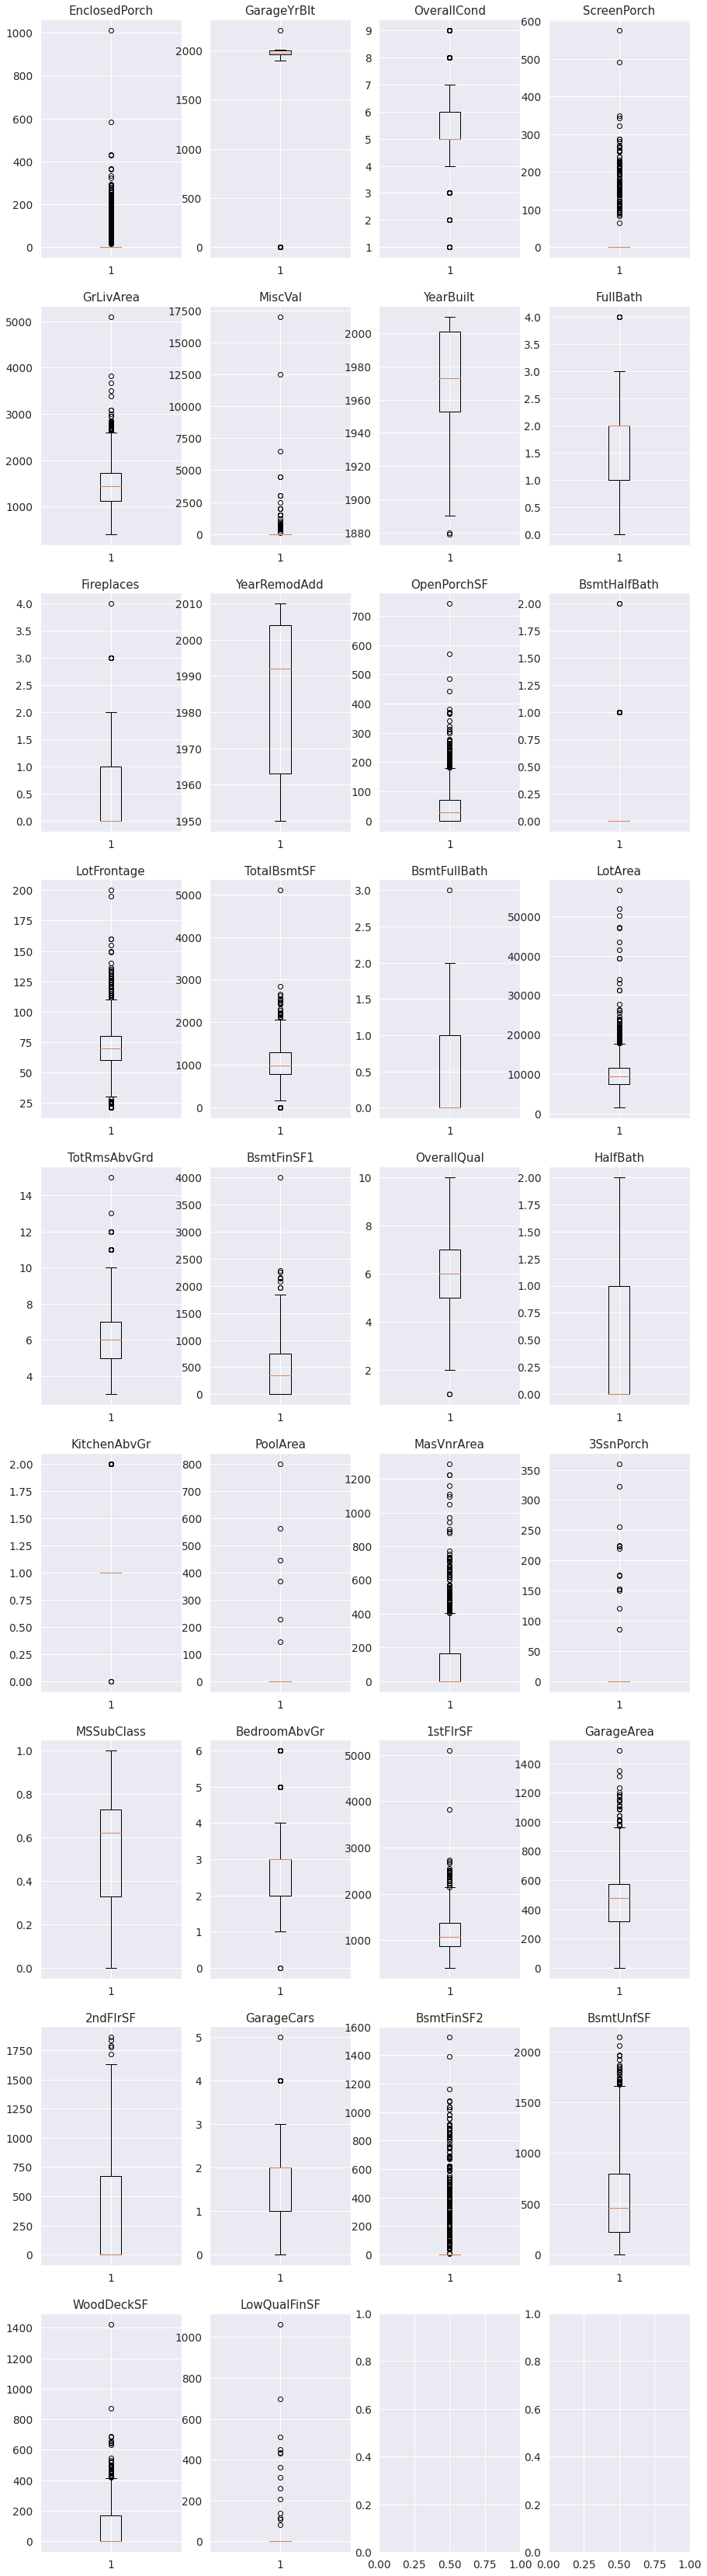

In [34]:
# boxplots for test data
test_data_points = non_nominal_vars.drop(df_train.index)
fig, axs = plt.subplots(9,4,figsize=(15,60))
for i, var_name in enumerate(possible_outlier_cols):
    axs[i//4,i%4].boxplot(test_data_points[var_name])
    axs[i//4,i%4].set_title(var_name)
plt.show()

In the end, we decided on removing the following outliers:
1. '3SsnPorch' column, value>500
2. 'MasVnrArea' column, value>1400
3. 'LotArea' column, value>100000
4. 'GrLivArea' column, value>4000 & Saleprice<300000

### 1.4.3 Removing outliers

In [35]:
outlier_filter = (df_train['3SsnPorch']>500) |  (df_train['MasVnrArea']>1400) | (df_train['LotArea']>100000) | ((df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000))
non_nominal_vars.drop(df_train[outlier_filter].index, inplace=True)

## 1.5 Transforming the target and predictors
<span style="color:red">NOTE8: Combines "Dealing with highly skewed features" and "1.3 SalePrice".</span>
The Homoskedasticity assumption states that the residuals should be relatively consistent and normally distributed across all values of the predictor. In order to match this assumption, we need the predictor features and target to be normally distributed. We use Box-cox transform and log transform for this purpose.
### 1.5.1 Target feature

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



mu= 180576.96 and sigma= 79339.77



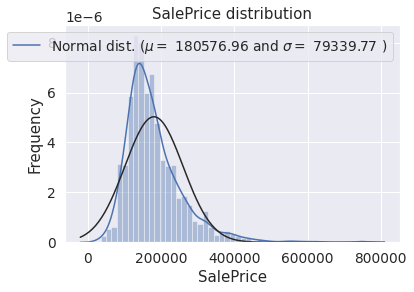

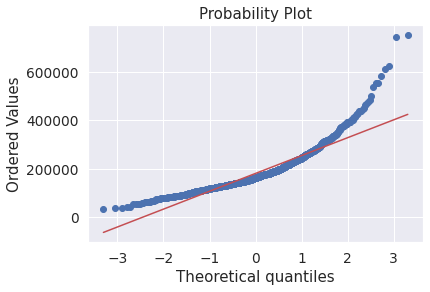

In [36]:
untransformed_prices = non_nominal_vars['SalePrice'].drop(df_test.index)
sns.distplot(untransformed_prices, fit=norm)

# get the fitted parameters used by the function
(mu, sigma) = norm.fit(untransformed_prices)
print('\nmu= {:.2f} and sigma= {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(untransformed_prices, plot=plt)
plt.show()

Since the target feature is not severely skewed, we can simply use log-transform and save ourselves a parameter.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 180576.96 and sigma = 79339.77



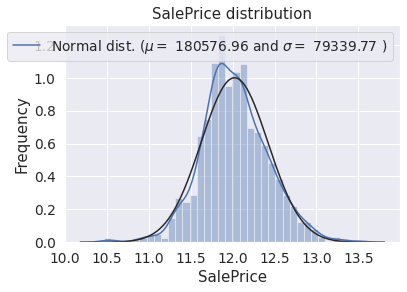

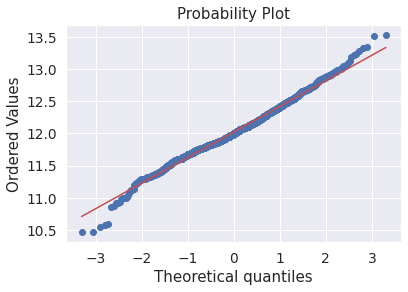

In [37]:
# Using log1p, which applies log(1+x) 
non_nominal_vars['SalePrice'].loc[untransformed_prices.index] = np.log1p(untransformed_prices)
transformed_prices = non_nominal_vars['SalePrice'].drop(df_test.index)
sns.distplot(transformed_prices, fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(untransformed_prices)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(transformed_prices, plot=plt)
plt.show()

### 1.5.2 Dealing with highly skewed features
#### 1.5.2.1 Overview

In [38]:
numeric_feats = non_nominal_vars.columns[[not isinstance(c, int) for c in non_nominal_vars.columns]]

# Check the skew of all numerical features
skewed_feats = non_nominal_vars[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940235
PoolQC,20.320342
PoolArea,17.670290
LowQualFinSF,12.071863
3SsnPorch,10.762248
KitchenAbvGr,4.295433
BsmtFinSF2,4.157618
EnclosedPorch,3.997699
ScreenPorch,3.953436
BsmtHalfBath,3.939684


#### 1.5.2.2 Box-Cox Transformation of (highly) skewed features
We use the scipy function boxcox1p which computes the Box-Cox tranformation of $1+x$. Note that setting $\lambda = 0$ is equivalent to log1p used above for SalePrice

In [39]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    non_nominal_vars[feat] = boxcox1p(non_nominal_vars[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 58 skewed numerical features to Box Cox transform


## 1.6 Scaling everything
Since we will be using some degree of regularization in pretty much all of our models, we want the regularizor to penalize all features equally. To achieve this we need all features to be on the same scale. Since we didn't remove most outliers, we will use RobustScaler for scaling.

In [40]:
no_price_cols = list(non_nominal_vars.columns)
no_price_cols.remove('SalePrice')
predictors = pd.DataFrame(RobustScaler().fit_transform(non_nominal_vars.drop(['SalePrice'], axis=1)), columns=no_price_cols, index=non_nominal_vars.index)
# Since the area of the house is an important feature in housing prices, we can add one more feature,
# which is the sum of the basement, first, and second square-feet of each house
predictors['TotalSF'] = predictors['TotalBsmtSF'] + predictors['1stFlrSF'] + predictors['2ndFlrSF']
response = transformed_prices

In [41]:
predictors

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,ExterQual,ExterCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,TotalSF
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.256476,-0.256857,0.469532,0.000000,0.622046,0.254932,1.053957,0.147116,0.0,-0.815369,-0.285654,-0.502725,1.046892,0.0,0.397131,1.0,0.000000,0.0,1.0,0.000000,0.0,0.891567,-1.0,0.588120,0.000000,0.235111,0.000000,0.243175,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.224954,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.258512
2,0.469964,0.036513,0.000000,2.680718,0.062565,-0.435889,0.000000,0.226328,0.0,-0.374586,0.502046,0.339990,0.000000,0.0,-0.303602,0.0,0.730463,0.0,0.0,0.000000,0.0,0.000000,0.0,-0.022751,0.000000,-0.069777,1.166466,-0.714219,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.349597,0.119331,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.842035
3,-0.100689,0.409099,0.469532,0.000000,0.580823,0.229487,1.000000,0.061026,0.0,-0.056992,-0.142809,-0.349903,1.050333,0.0,0.500081,1.0,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.0,0.543111,0.000000,0.419940,0.000000,0.132386,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,1.000000,0.224954,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.557620
4,-0.530036,0.024396,0.469532,0.000000,-1.225762,-0.590492,0.000000,-0.109919,0.0,0.114840,-0.528148,-0.256682,1.017141,0.0,0.406774,1.0,0.000000,-1.0,0.0,0.000000,0.0,0.469532,0.0,0.475526,0.747314,0.517903,0.000000,0.080746,8.797736,0.0,0.0,0.0,0.000000,0.0,0.0,-1.0,0.000000,0.119331,0.0,-0.457193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.232312
5,0.644214,0.982859,0.891567,0.000000,0.560199,0.178566,1.228246,0.129436,0.0,0.037734,0.300268,0.124119,1.099314,0.0,1.000886,1.0,0.000000,0.0,1.0,0.805929,0.0,1.275461,0.0,0.520593,0.747314,1.004886,1.037482,0.343706,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,1.747314,0.224954,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.523701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,-3.794380,-3.267151,-1.142249,1.885128,-0.062646,-0.590492,0.000000,-0.844285,0.0,0.123681,-1.142190,-1.419084,0.940348,0.0,-0.626229,0.0,0.000000,-1.0,1.0,0.000000,0.0,-0.530468,-1.0,-203.870477,-2.574768,-6.976590,0.000000,-0.714219,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,-1.0,0.000000,-0.775046,0.0,-0.457193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.620925
2916,-3.794380,-3.307113,-1.142249,0.000000,-0.062646,-0.590492,0.000000,-0.079034,0.0,-0.349433,-1.142190,-1.419084,0.940348,0.0,-0.626229,0.0,0.000000,-1.0,1.0,0.000000,0.0,0.000000,-1.0,-0.1594

In [42]:
response

Id
1       12.247699
2       12.109016
3       12.317171
4       11.849405
5       12.429220
          ...    
1456    12.072547
1457    12.254868
1458    12.493133
1459    11.864469
1460    11.901590
Name: SalePrice, Length: 1452, dtype: float64

# 2 Models
Now we try some models on our processed data set. We will separate our training data into a training set, used to train the models and cross-validate <b>within</b> a model, and a dev set, used to compare the performances of different models. Some of our models have automatic CV, which is convenience for determining the best hyperparameters; for those that don't have this luxury, we use GridSearch when there are few hyperparameters to tune, and Bayesian optimizer tool Hyperopt when there are more hyperparameters.

In [43]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import xgboost as xgb
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope

In [44]:
train_predictors, dev_predictors, train_response, dev_response = train_test_split(predictors.drop(df_test.index), response, test_size=0.1)
test_predictors = predictors.loc[df_test.index]

## 2.1 Linear Models
### 2.1.1 Lasso regression
So we all know Lasso uses L1 regularization and thus eliminate unimportant features, making it suitable for a relatively messy data set with only few truely important features. Another advantage of L1 regularization is the relative robustness towards outliers, since an outlier's affect on regularization is linear instead of quadratic (as in the case of L2 regularization).

In [45]:
model_lasso_CV = LassoCV().fit(train_predictors, train_response)
((model_lasso_CV.predict(dev_predictors) - dev_response)**2).mean()**.5

0.11442376753371447

### Inspecting feature importance

In [46]:
coef=pd.Series(model_lasso_CV.coef_, index=predictors.columns)
print("Lasso picked " + str(sum(coef != 0)) +
      " variables and eliminated the other " +
      str(sum(coef == 0)) + " variables")

Lasso picked 29 variables and eliminated the other 124 variables


In [47]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
new_index = list(imp_coef.index)
for ei, i in enumerate(new_index):
    if isinstance(i, int):
        new_index[ei] = OH_groups[i]+' '+str(i)
imp_coef = pd.Series(imp_coef.values, index=new_index)
imp_coef

BsmtUnfSF       -0.008662
BsmtFinSF2      -0.001803
EnclosedPorch   -0.001470
GarageYrBlt     -0.000549
MiscVal         -0.000345
RoofStyle 29    -0.000000
RoofStyle 30    -0.000000
RoofStyle 31     0.000000
RoofStyle 32    -0.000000
RoofStyle 33     0.000000
ExterQual        0.024182
BsmtFinSF1       0.025374
1stFlrSF         0.030674
LotArea          0.032615
KitchenQual      0.038127
OverallCond      0.041071
Neighborhood     0.077770
YearBuilt        0.081273
OverallQual      0.105642
GrLivArea        0.141454
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

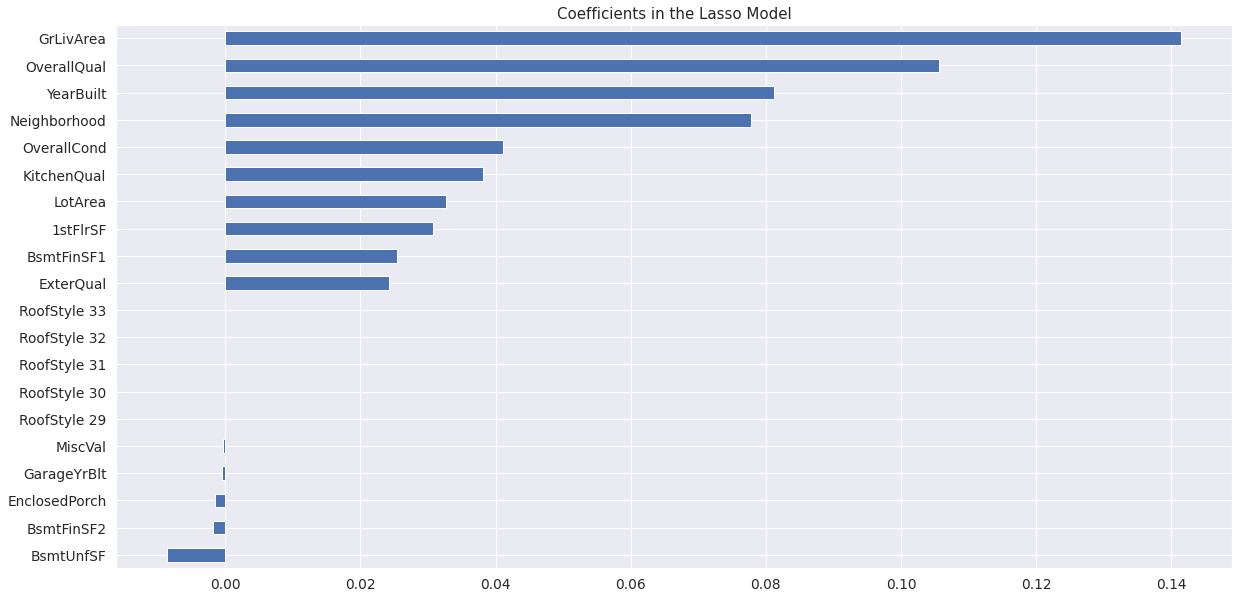

In [48]:
matplotlib.rcParams['figure.figsize'] = (20, 10.0)
imp_coef.plot(kind="barh")
plt.title("Coefficients in the Lasso Model")

It's good to see the features we added, <b>Neighborhood</b> and <b>TotalSF</b>, to be among the more important features selected by Lasso! In the mean time, many of the binary features simply got eliminated by Lasso -- that's a lot of discarded information, possibly part of the reason it gets outperformed by Ridge.

### 2.1.2 Ridge regression
Ridge regression obviously uses L2 regularization. Since a feature rarely gets entirely eliminated, Ridge regression is better on data sets that have lots of moderately important features. A good side effect of not eliminating features is that multicollinearity can be handled by assigning similar coefficients to correlated features, rather than stomping one of the features completely (as in the case of L1 regularization).

In [49]:
model_ridge_CV = RidgeCV().fit(train_predictors, train_response)
((model_ridge_CV.predict(dev_predictors) - dev_response)**2).mean()**.5

0.1104978065102972

We think the reason ridge regression outperforms Lasso regression in our case is that we have focused on outliers and feature engineering in our preprocessing but haven't done anything about multicollinearity.

### 2.1.3 ElasticNet
Combining L1 and L2 regularizations, so the best of both worlds?

In [50]:
model_net_CV = ElasticNetCV().fit(train_predictors, train_response)
((model_net_CV.predict(dev_predictors) - dev_response)**2).mean()**.5

0.11450419048278583

## 2.2 Support vector regressor
SVM for regression task. Just like SVM for classification, SVR regularizes its predictive model by minimizing its derivative, and tries to find a line that is within tolerence <b>epsilon</b> distance from all training points. There are not a lot of data points in our training set, so SVR being non-parametric shouldn't be a huge problem in terms of training time, either.

Note:
- This is also where we start to use Bayesian optimization for hyperparameter tuning. Bayesian optimization decides which set of hyperparameter to try next based on the performances of all sets of hyperparameters tried so far. In a way, it resembles exploration-exploitation algorithm in the sense that it prefers hyperparameter sets that perform well or haven't been tried.
- Hyperopt generally takes very long to run, so we comment out the sections where it is run and only show the 3 best sets of hyperparameters we have seen.

In [51]:
# svr_params = {
#     'kernel': 'poly',
#     'degree': scope.int(hp.quniform('degree', 1, 5, 1)),
#     'gamma': hp.choice('gamma', ['scale', 'auto', hp.uniform('custom_gamma', 0.001, 0.1)]),
#     'C': hp.uniform('C', 0.1, 20),
#     'epsilon': hp.uniform('epsilon', 0.05, 0.5),
# }

In [52]:
# def svr_objective(params):
#     model = SVR(**params)
#     score = cross_val_score(model, train_predictors, train_response, scoring='neg_mean_squared_error', cv=10).mean()
#     return -score

In [53]:
# svr_trials = Trials()
# svr_best = fmin(fn = svr_objective, space = svr_params, algo = tpe.suggest, max_evals = 100, trials = svr_trials)

In [54]:
# saves all trials, so we may look at them later and possibly find some more interesting patterns,
# such as which hyperparameters were tried more
# with open('svr_trials', 'wb') as f:
#     pickle.dump(svr_trials, f)
# svr_best

In [55]:
# 0.10764106408476232
# svr_best = {
#     'C': 19.975825015722275,
#     'degree': 1,
#     'epsilon': 0.050092622576697096,
#     'gamma': 'scale',
#     'kernel': 'poly'
# }
# 0.1074982256353979
# svr_best = {
#     'C': 19.5710457223302,
#     'degree': 1,
#     'epsilon': 0.06369258530852102,
#     'gamma': 'scale',
#     'kernel': 'poly'
# }
# 0.10540293724300769
svr_best = {
    'C': 1.66433466418043,
    'degree': 1,
    'epsilon': 0.05974127271765235,
    'gamma': 0.06894566850688523,
    'kernel': 'poly'
}

In [56]:
svr_model_CV = SVR(**svr_best)
svr_model_CV.fit(train_predictors, train_response)
((svr_model_CV.predict(dev_predictors) - dev_response)**2).mean()**.5

0.1098597478095575

## 2.3 Ensemble Learning
Ensemble methods encompass many of the most successful models today. The general idea behind ensemble learning is to train more than one models and integrate their predictions into a final prediction. Hopefully the variances of member models will cancel out each other, resulting a final model with both low bias and low variance. Member models can consist of individuals trained on different rows (samples) of the training set (a technique known as bagging), different columns (features) (known as random subspace method), or even different models entirely (stacking).
### 2.3.1 Random forest regressor
Similar to random forest classifier. Now each decision tree makes splits based on some threshold on the selected feature f, which splits the training set between data points whose f exceed the threshold, and points that don't. For each half, the prediction becomes the average of all target values belonging to that half; the "entropy" of the split is then measured by the average error of two halves. So we end up with a stair-like model, if that helps with the intuition. Decision trees are by themselves prone to overfitting, but ensembling a number of them helps cancel out the variance.

In [57]:
# forest_model = RandomForestRegressor()
# forest_params = [
#     {'bootstrap': [False], 'n_estimators': [80,90,100], 'max_features': [20,30,40]}
# ]
# forest_grid = GridSearchCV(forest_model, forest_params, cv=10, scoring='neg_mean_squared_error')
# forest_grid.fit(train_predictors, train_response)

In [58]:
# forest_scores = forest_grid.cv_results_
# for mean_score, params in zip(forest_scores["mean_test_score"], forest_scores["params"]):
#     print(np.sqrt(-mean_score), params)

In [59]:
forest_model_CV = RandomForestRegressor(bootstrap=False, n_estimators=90, max_features=30)
forest_model_CV.fit(train_predictors, train_response)
((forest_model_CV.predict(dev_predictors) - dev_response)**2).mean()**.5

0.1161473474400092

### 2.3.2 Adaboost
"An AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction."

-quoted from the sklearn doc, I think it sums up the intuition pretty well

In [60]:
# ada_model = AdaBoostRegressor(loss='exponential')
# ada_params = [
#     {'n_estimators': [70,80,90], 'learning_rate':[0.4,0.5,0.6]}
# ]
# ada_grid = GridSearchCV(ada_model, ada_params, cv=10, scoring='neg_mean_squared_error')
# ada_grid.fit(train_predictors, train_response)

In [61]:
# ada_scores = ada_grid.cv_results_
# for mean_score, params in zip(ada_scores["mean_test_score"], ada_scores["params"]):
#     print(np.sqrt(-mean_score), params)

In [62]:
ada_model_CV = AdaBoostRegressor(n_estimators=80, learning_rate=0.5, loss='exponential')
ada_model_CV.fit(train_predictors, train_response)
((ada_model_CV.predict(dev_predictors) - dev_response)**2).mean()**.5

0.1477712717899301

### 2.3.3 Light gradient boost

In [63]:
# lgb_train_set = lgb.Dataset(train_predictors, train_response)
# def lgb_objective(params):
#     cv_results = lgb.cv(params, lgb_train_set, nfold = 10, num_boost_round = 10000, 
#                         early_stopping_rounds = 100, metrics = 'rmse', seed = 50, stratified=False)
#     best_score = min(cv_results['rmse-mean'])
#     return {'loss': best_score, 'params': params, 'status': STATUS_OK}

In [64]:
# lgb_params = {
#     'objective': 'regression',
#     'metrics':'rmse',
#     'num_leaves': scope.int(hp.quniform('num_leaves', 2, 8, 2)),
#     'n_estimators': scope.int(hp.quniform('n_estimators', 2000, 4000, 100)),
#     'learning_rate': hp.uniform('learning_rate', 0.05, 0.15),
#     'feature_fraction': hp.uniform('feature_fraction', 0.2, 1),
#     'bagging_fraction': hp.uniform('bagging_fraction', 0.85, 1),
#     'bagging_freq': scope.int(hp.quniform('bagging_freq', 1, 5, 1)),
#     'verbose':-1
# }

In [65]:
# lgb_trials = Trials()
# lgb_best = fmin(fn = lgb_objective, space = lgb_params, algo = tpe.suggest, max_evals = 100, trials = lgb_trials)

In [66]:
# with open('lgb_trials', 'wb') as f:
#     pickle.dump(lgb_trials, f)
# lgb_best

In [67]:
# 0.10163029699627968
# lgb_best = {
#     'bagging_fraction': 0.9004497665995926,
#     'bagging_freq': 1,
#     'feature_fraction': 0.20216553574313123,
#     'learning_rate': 0.0724549399881678,
#     'n_estimators': 2700,
#     'num_leaves': 4
# }
# 0.1013690843774026
# lgb_best = {
#     'bagging_fraction': 0.9062327932724584,
#     'bagging_freq': 4,
#     'feature_fraction': 0.32371136297639824,
#     'learning_rate': 0.050445708456683974,
#     'n_estimators': 2300,
#     'num_leaves': 8
# }
# 0.09936387814633703
lgb_best = {
    'bagging_fraction': 0.8787672647570306,
    'bagging_freq': 1,
    'feature_fraction': 0.8698118323091124,
    'learning_rate': 0.0710761926271104,
    'n_estimators': 2800,
    'num_leaves': 2
}

In [68]:
lgb_model_CV = lgb.LGBMRegressor(**lgb_best)
lgb_model_CV.fit(train_predictors, train_response)
((lgb_model_CV.predict(dev_predictors) - dev_response)**2).mean()**.5

[LightGBM] [Warning] feature_fraction is set=0.8698118323091124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8698118323091124
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8787672647570306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8787672647570306


0.11369504730325923

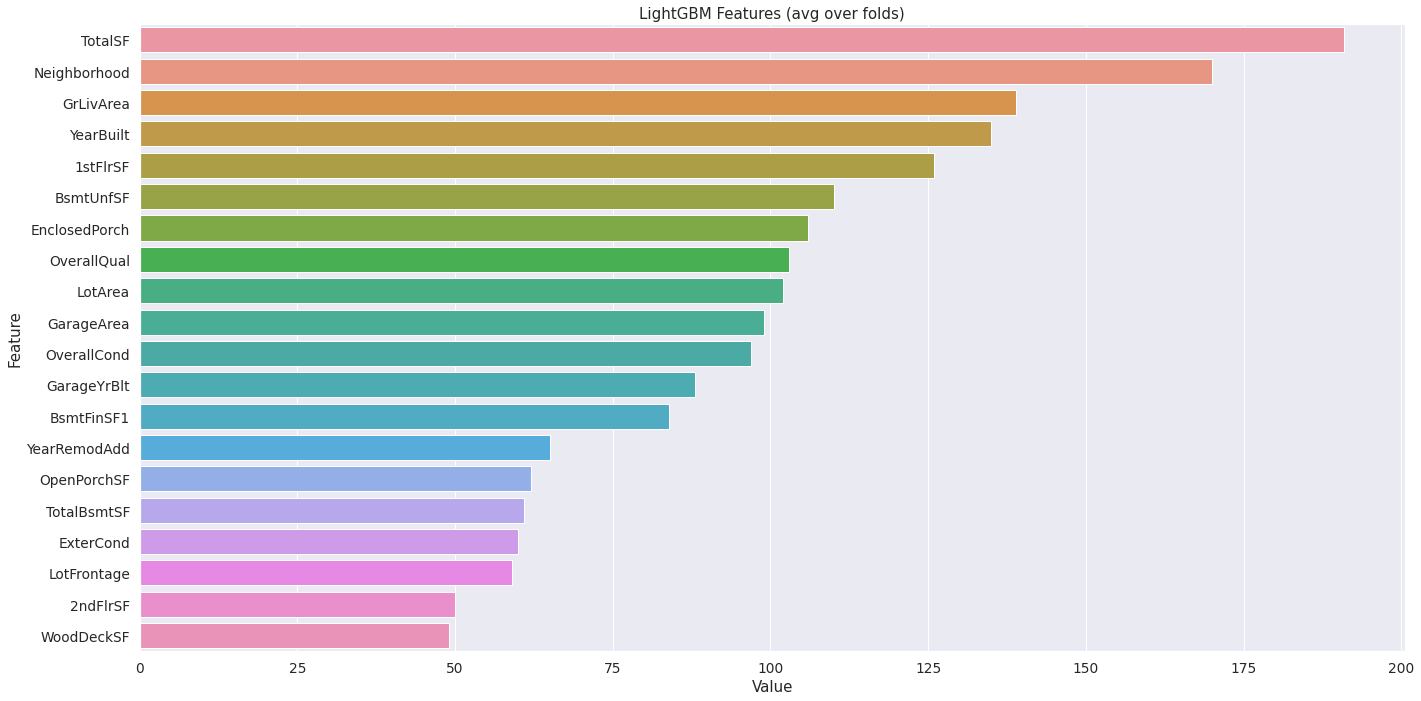

In [69]:
feature_imp = pd.DataFrame(zip(lgb_model_CV.feature_importances_,predictors.columns), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

### 2.3.4 Extreme gradient boost

In [70]:
# xgb_train_set = xgb.DMatrix(train_predictors.values, train_response.values)
# def xgb_objective(params):
#     cv_results = xgb.cv(params, xgb_train_set, nfold = 10, num_boost_round = 10000, 
#                         early_stopping_rounds = 100, metrics = 'rmse', seed = 50, stratified=False)
#     best_score = min(cv_results["test-rmse-mean"])
#     return {'loss': best_score, 'params': params, 'status': STATUS_OK}

In [71]:
# xgb_params = {
#     'objective':'reg:squarederror',
#     'max_depth': scope.int(hp.quniform('max_depth', 2, 8, 1)),
#     'min_child_weight': hp.uniform('min_child_weight', 0, 1),
#     'n_estimators': scope.int(hp.quniform('n_estimators', 3000, 5000, 100)),
#     'eta': hp.uniform('eta', 0, 0.1),
#     'alpha': hp.uniform('alpha', 0, 0.1),
#     'gamma': hp.uniform('gamma', 0, 0.1),
#     'lambda': hp.uniform('lambda', 0, 10),
#     'subsample': hp.uniform('subsample', 0.6, 1.0),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
# }

In [72]:
# xgb_trials = Trials()
# xgb_best = fmin(fn = xgb_objective, space = xgb_params, algo = tpe.suggest, max_evals = 100, trials = xgb_trials)

In [73]:
# with open('xgb_trials', 'wb') as f:
#     pickle.dump(xgb_trials, f)
# xgb_best

In [74]:
# 0.093642301648737
# xgb_best = {
#     'alpha': 0,
#     'colsample_bytree': 0.7,
#     'eta': 0.01,
#     'gamma': 0,
#     'lambda': 1,
#     'max_depth': 3,
#     'min_child_weight': 0,
#     'n_estimators': 3400,
#     'subsample': 0.7
# }
# 0.09670642386469297
# xgb_best = {
#     'alpha': 0.06421549163951845,
#     'colsample_bytree': 0.7540047602364598,
#     'eta': 0.013779239232138842,
#     'gamma': 0.01511692325849772,
#     'lambda': 0.11710404510546712,
#     'max_depth': 3,
#     'min_child_weight': 0.20486229536113576,
#     'n_estimators': 4600,
#     'subsample': 0.7900177142549496
# }
# 0.09495873571105731
xgb_best = {
    'alpha': 0.0841173384802506,
    'colsample_bytree': 0.7876049986466767,
    'eta': 0.007048307982511789,
    'gamma': 0.004497989399959483,
    'lambda': 1.253293996494506,
    'max_depth': 3,
    'min_child_weight': 0.2518394698236566,
    'n_estimators': 3100,
    'subsample': 0.669638965124859
}

In [75]:
xgb_model_CV = xgb.XGBRegressor(**xgb_best)
xgb_model_CV.fit(train_predictors, train_response)
((xgb_model_CV.predict(dev_predictors) - dev_response)**2).mean()**.5

0.10418909679390266

# 3 Compare, stack, and output
According to our dev errors, the only model that doesn't work very well is Adaboost. Among the remaining models, ensembling methods tend to outperform linear regression methods, but that should be taken with a grain of salt because ensembling methods are very powerful and tend to overfit. Anyways, we mentioned stacking earlier as one of the ensembling concepts. We use it here now to combine all our current models except for AdaBoost into our final submission, hopefully with lower variance and better performance!

In [76]:
from mlxtend.regressor import StackingCVRegressor
stack_model = StackingCVRegressor(regressors=(model_lasso_CV, model_ridge_CV, model_net_CV, svr_model_CV),
                                  meta_regressor=model_lasso_CV, use_features_in_secondary=True)
stack_model.fit(predictors.drop(df_test.index).values, response.values)

StackingCVRegressor(meta_regressor=LassoCV(),
                    regressors=(LassoCV(),
                                RidgeCV(alphas=array([ 0.1,  1. , 10. ])),
                                ElasticNetCV(),
                                SVR(C=1.66433466418043, degree=1,
                                    epsilon=0.05974127271765235,
                                    gamma=0.06894566850688523, kernel='poly')),
                    use_features_in_secondary=True)

In [77]:
stack_preds = np.expm1(stack_model.predict(test_predictors.values))
blend_preds = 0.15*np.expm1(lgb_model_CV.predict(test_predictors.values)) + 0.15*np.expm1(lgb_model_CV.predict(test_predictors.values)) + 0.7*stack_preds
solution = pd.DataFrame({"Id":df_test.index, "SalePrice":blend_preds})
solution.to_csv("submission.csv", index = False)